# 1 Define the Model

If you want to use outside of a notebook then save the bellow model def in a `.py` file

The in the main file `from filename.py import FaceDetector`

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

class RegHead(nn.Module):
    def __init__(self,in_channels, S, B, dropout=0.0):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels, 1024, 3, padding=1)
        self.conv1 = nn.Conv2d(1024, 1024, 3, padding=1)
        self.conv2 = nn.Conv2d(1024, 1024, 3, padding=1)
        self.conv3 = nn.Conv2d(1024, 1024, 3, padding=1)

        # self.l0 = nn.Linear((4096 * S * S), 4096)
        self.l0 = nn.Linear((1024 * S * S), 4096)
        self.drop = nn.Dropout(dropout)
        self.act = nn.LeakyReLU(0.1)
        self.l1 = nn.Linear(4096, (S * S * (B * 5)))

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.flatten(start_dim=1)
        x = self.l0(x)
        x = self.drop(x)
        x = self.act(x)
        x = self.l1(x)
        return x




class FaceDetector(nn.Module):
    def __init__(self, S=7, B=2, dropout=0.0):
        super(FaceDetector, self).__init__()

        backbone = models.resnet50(pretrained=True)
        self.backbone = torch.nn.Sequential(*(list(backbone.children())[:-2]))
        
        self.regression_head = RegHead(2048, S, B, dropout=dropout)
    
    def forward(self, x):
        features = self.backbone(x)
        out = self.regression_head(features)
        return out

# 2 init the model

In [4]:
path_to_saved_model = '/home/kuba/projects/swvl/week03/experiments/try14/best_dev_loss.pt'
model = FaceDetector()
model.load_state_dict(torch.load(path_to_saved_model, weights_only=True))


/home/kuba/.virenv/base/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kuba/.virenv/base/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

NOW you can use the model !

# 3 NOTE
Before using the modle note two things:
- How input must be structured
    - The pre process 
    - The Batch Dimension

### Batch Dim

In [5]:
test = torch.load('/home/kuba/Documents/data/raw/me-img/tensor/clear_straighton.pt')
test.shape

torch.Size([3, 224, 224])

In [6]:
# it is missing the batch dim so we will have error
# we must add batch dim
test = test.unsqueeze(dim=0)
test.shape

torch.Size([1, 3, 224, 224])

### The pre process

<span style="color:red;"> SO WE ARE NO LONGER NORMALIZING TO BE LIKE IMG NET </span>


In [7]:
#inputs must be tensors and be 224x224
#its also recommender they are normalized to how the model was trained
from torchvision import transforms
from PIL import Image
import torch


f_img = f'/home/kuba/Documents/data/raw/me-img/raw/sun.jpeg'
name = 'sun'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224), antialias=True)  # Resize all images to same dimensions
])


img = Image.open(f_img)
img_tensor = transform(img) #you must

torch.save(img_tensor, f'/home/path/to/go/{name}.pt')

RuntimeError: Parent directory /home/path/to/go does not exist.

# 4 Using the model

In [17]:
#this can be done as such 
with torch.no_grad():
    res = model(test)

res = res.view(-1, 7, 7, 10)  #we have img split up into a 7x7 grid in each cell we have two prediction 
#each prediction is (confidance, x, y, width, height) the x,y,w,h are all relative to cell size
res.shape

torch.Size([1, 7, 7, 10])

# 5 Vizualizing the preds

In [18]:
import torchvision.ops as ops
def non_max_supp(preds, confidence_threshold = 0.35, iou_threshold=0.5, S=7, return_type='xywh'):
    batch_size = preds.shape[0]
    all_res = []


    for i in range(batch_size):
        pred = preds[i]

        all_scores = []
        all_boxes_xyxy = []
        all_boxes_xywh = []
        for row in range(S):
            for col in range(S):

                if pred[row, col][0] < confidence_threshold:
                    continue


                x_cell, y_cell, w_cell, h_cell = pred[row, col][1:5]
                
                x_img = (col + x_cell) / S
                y_img = (row + y_cell) / S
                w_img = w_cell / S
                h_img = h_cell / S
                
                x1 = x_img - w_img / 2
                y1 = y_img - h_img / 2
                x2 = x_img + w_img / 2
                y2 = y_img + h_img / 2

                all_scores.append(pred[row, col][0])
                all_boxes_xyxy.append(torch.tensor((x1,y1,x2,y2))) #for the nms calculation
                all_boxes_xywh.append(torch.tensor((x_img,y_img,w_img,h_img))) #for we will use to plot easy later

        #if no prediction has highenough confidace then we get rid of it
        if len(all_boxes_xyxy) == 0:
            all_res.append(torch.tensor([]))
            continue

        #here we get the idx of the valid boxes after non max suppreshion
        res = ops.nms(torch.stack(all_boxes_xyxy), torch.stack(all_scores), iou_threshold=iou_threshold)
        # for each of the idx we combine now with confidacne  
        if return_type == 'xywh':
            keep_boxes = [ torch.cat((all_scores[idx].unsqueeze(0), all_boxes_xywh[idx][:])) for idx in res]
        elif return_type == 'xyxy':
            keep_boxes = [ torch.cat((all_scores[idx].unsqueeze(0), all_boxes_xyxy[idx][:])) for idx in res]
        #we append to the total preds list for each batch
        all_res.append(torch.stack(keep_boxes))
        
    return all_res

In [19]:
res = non_max_supp(res, return_type='xywh')
#res is now a list of suppresed preds on the specified return type (confidace, type, type, type, type)
#type is xyxy or xywh
len(res)

1

# 6 plotting

In [20]:
import matplotlib.pyplot as plt
def plot_post_non_max(img, preds, preds_type='cx,cy,w,h', labels=[], labels_type='cx,cy,w,h'):
    img = img.permute(1, 2, 0) #to go from (3 x W x H) to (W x H x 3)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    img_w, img_h = img.shape[:2]

    def plot_cxcywh_style(labels, img_w, img_h, color, marker='ro', show_confidance=False):
         for label in labels:
            print(label)
            confidance, center_x, center_y, width, height = label
            center_x, center_y, width, height = int(center_x * img_w), int(center_y * img_h), int(width * img_w), int(height * img_h)
            xmin = center_x - width/2
            xmax = center_x + width/2
            ymin = center_y - height/2
            ymax = center_y + height/2
            
            #  center and text
            if show_confidance:
                plt.text(center_x, center_y, f"{confidance.item():.3f}", bbox=dict(facecolor='white', alpha=0.35, boxstyle='round'), fontsize=8)
            plt.plot(center_x, center_y, marker)

            
            # (horizontal lines)
            plt.hlines(ymin, xmin=xmin, xmax=xmax, colors=color)
            plt.hlines(ymax, xmin=xmin, xmax=xmax, colors=color)
            
            # (vertical lines)
            plt.vlines(xmin, ymin=ymin, ymax=ymax, colors=color)
            plt.vlines(xmax, ymin=ymin, ymax=ymax, colors=color)
         

    if preds_type == 'cx,cy,w,h':
        plot_cxcywh_style(preds, img_w, img_h, 'red', 'ro', True)

    if len(labels) != 0 and labels_type == 'cx,cy,w,h':
        plot_cxcywh_style(labels, img_w, img_h, 'green', 'g1')
    
    plt.axis('off')
    plt.show()

In [21]:
res

[tensor([[1.0383, 0.5331, 0.5629, 0.2591, 0.3627]])]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1131592..2.5461626].


tensor([1.0383, 0.5331, 0.5629, 0.2591, 0.3627])


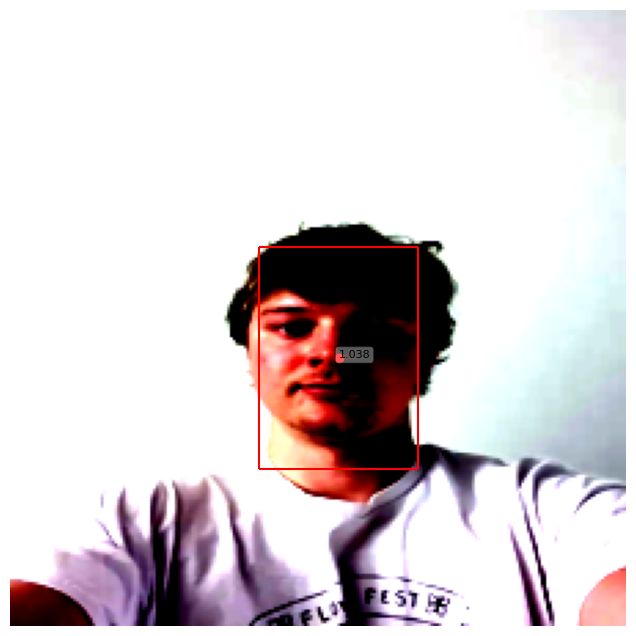

In [23]:
plot_post_non_max(test[0], res[0])
#we specify the 0 to get rid of the batch dim